## PH4044 Tutorial 3

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.integrate as integrate

### Question 1

#### NOTES TO MYSELF
- Question seems to allow use to vary $\eta_f$. The challenge is going to be comming up with a suitable scale. 
- $E$ / $eta$ we can intentionally set to a specific value I think and vary $\eta_f$ around it.

In [10]:
# Define all constants
T = 23 + 273.15 # K
m_0 = 9.109E-31 # kg
k_B = 1.381E-23 # J/K
hbar = 1.055E-34

In [3]:
# Define the effective concentration
def N_c(m_e, T):
    return 2*((m_e*k_B*T)/(2*np.pi*hbar**2))**(3/2)

# Define the Fermi Integral
def F_half(eta_f):
    F_half_values = []
    for eta_value in eta_f:
        integrand = lambda eta: (eta**(1/2))/(1+np.exp(eta-eta_value))
        F_half_values.append(integrate.quad(integrand, 0, np.inf)[0])
    return np.array(F_half_values)
    

# Define the n using the Fermi-dirac distribution 
def n_f(eta_f, m_e, T):
    return (2/np.sqrt(np.pi))*N_c(m_e, T)*F_half(eta_f)

# Define n using the Boltzmann Approximation
def n_b(eta_f, m_e, T):
    return N_c(m_e, T)*np.exp(eta_f)

In [4]:
eta_f = np.arange(0, 10, 0.1)
n_f(eta_f, m_0, T)
n_b(eta_f, m_0, T)

/var/folders/0m/gfqnwnj15yb3_ysgltf_03440000gn/T/ipykernel_1006/3274783136.py:9: RuntimeWarning: overflow encountered in exp
  integrand = lambda eta: (eta**(1/2))/(1+np.exp(eta-eta_value))


array([2.45904791e+25, 2.71766824e+25, 3.00348790e+25, 3.31936748e+25,
       3.66846841e+25, 4.05428460e+25, 4.48067743e+25, 4.95191439e+25,
       5.47271177e+25, 6.04828190e+25, 6.68438526e+25, 7.38738819e+25,
       8.16432659e+25, 9.02297631e+25, 9.97193101e+25, 1.10206882e+26,
       1.21797440e+26, 1.34606989e+26, 1.48763730e+26, 1.64409348e+26,
       1.81700430e+26, 2.00810031e+26, 2.21929406e+26, 2.45269925e+26,
       2.71065189e+26, 2.99573363e+26, 3.31079769e+26, 3.65899732e+26,
       4.04381743e+26, 4.46910942e+26, 4.93912976e+26, 5.45858258e+26,
       6.03266672e+26, 6.66712781e+26, 7.36831577e+26, 8.14324830e+26,
       8.99968120e+26, 9.94618593e+26, 1.09922354e+27, 1.21482989e+27,
       1.34259467e+27, 1.48379658e+27, 1.63984883e+27, 1.81231324e+27,
       2.00291589e+27, 2.21356439e+27, 2.44636699e+27, 2.70365365e+27,
       2.98799939e+27, 3.30225002e+27, 3.64955069e+27, 4.03337729e+27,
       4.45757128e+27, 4.92637814e+27, 5.44448986e+27, 6.01709185e+27,
      

### NOTES TO MYSELF
- The reason I've got these crazy values is because I'm totally ignoring the scale of $E_f$, $E_c$ and $kT$ when generating my $\eta_f$ values. 
- I need to generate values that are on the correct order of magnitude. 
- I would also generally expect $\eta_f < 0$ if the fermi energy is lower than the conduction band energy (which it should be in almost every case bar maybe doping). 

/var/folders/0m/gfqnwnj15yb3_ysgltf_03440000gn/T/ipykernel_1006/3274783136.py:9: RuntimeWarning: overflow encountered in exp
  integrand = lambda eta: (eta**(1/2))/(1+np.exp(eta-eta_value))


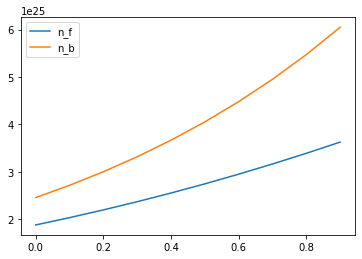

In [5]:
# Plot n_b against n_f 
eta_f = np.arange(0, 1, 0.1)

fig = plt.figure()
plt.plot(eta_f, n_f(eta_f, m_0, T), label='n_f')
plt.plot(eta_f, n_b(eta_f, m_0, T), label='n_b')
plt.legend()


### Question 2

#### NOTES TO MYSELF
Okay, what do I need to do here?

a) State whether the semiconductor is n-type or p-type 
    - $V_H$ is negative, which suggests work is done by the electric field in moving positive charge in the direction idicated by the arrow on the diagram
    - This suggests a build up of negative charge on the top plate or a build up of positive charge on the bottom plate 
    - Given both electrions and holes will be forced onto the bottom plate by the magnetic field, we thus conclude an excess of holes. It is a p-type dopant. (However, given the equations in the slides, I would imagine the negative sign indicates a build-up of electrons)

b) I imagine there is some sort of equation for that 
    - 

c) Can we equate current density to the current and sub in the value we've been given for D_p? Wait, that includes the temperature. Maybe we could assume room temp? Hmm, that might do-away with the neccessary assumptions for a Boltzmann dist approximation

### Question 3

What do I need to do? 

- Solve the differential equation using a differential equation solver 
- Plot the carrier density for different temperatures and applied electric fields
- Use the analytic solution to verify the results 

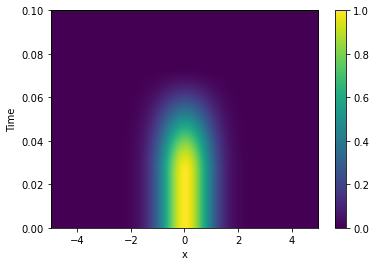

In [11]:
# We can us the py-pde library to solve the differential equation 
import pde 

# Define all the constants in the equation 
mu_p = 300e-4 # m^2 V^-1 s^-1 
T = 10 # K
E_0 = 100 # J
tau_p = 1e-6 # s
e = 1.6e-19 # C
D_p = (mu_p * k_B * T) / e # I think units are Q m^2 s-1 though this doesn't make sense if J is current density.

# Set up a grid of cartesian coordinates for the equation to solve
grid = pde.CartesianGrid([[-5, 5]], [101])

# Set up a Scalar Field which will correspond to the excess carriers 
delta_p = pde.ScalarField.from_expression(grid, "exp(-x**2)")
# Now we can encode the partial differential equation (notes below on the formatting)
# eq = pde.PDE({"p": "D_p * d2_dx2(p) - mu_p * E_0 * d_dx(p) - p / tau_p"}, consts=constants)
eq = pde.PDE({"p": f"({D_p}*d2_dx2(p)) - ({mu_p * E_0}*d_dx(p)) - (p / {tau_p})"})
# And solve 
storage = pde.MemoryStorage()
result = eq.solve(delta_p, t_range=0.1, dt = 1e-6, tracker=storage.tracker(0.1))

pde.plot_kymograph(storage)

In [78]:
D_p

2.5893749999999996e-05

Now that we've got the general code working, we can use it to explore the scenario set out in the question - largely, that we have $P_0$ = 1 at $x=t=0$

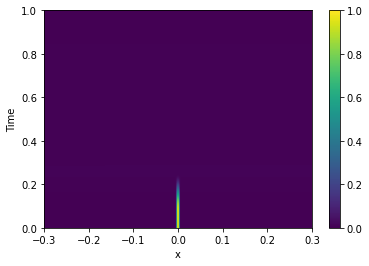

In [12]:
import math 

# Set up the initial grid 
# grid = pde.CartesianGrid([[-1e-10, 1e-10]], [101])
grid = pde.CartesianGrid([[-0.3, 0.3]], [101])

# Create an initial delta_p distribution with total carriers P_0 = 1 at x = t = 0
data = np.zeros(101)
data[len(data)//2] = 1

delta_p = pde.ScalarField(grid, data=data)

# Solve and display equation solutions 
#eq = pde.PDE({"p": f"{D_p}*d2_dx2(p) - {mu_p * E_0}*d_dx(p) - p / {tau_p}"})
eq = pde.PDE({"p": "d2_dx2(p) - d_dx(p) - p"})

storage = pde.MemoryStorage()
result = eq.solve(delta_p, t_range=1, dt = 1e-7, tracker=storage.tracker(0.2))

pde.plot_kymograph(storage)

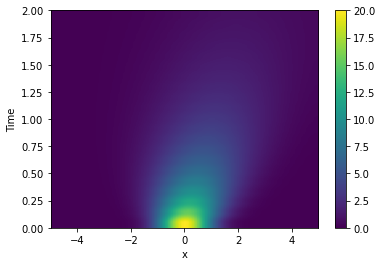

In [56]:
# We can us the py-pde library to solve the differential equation 
import pde 

# Define all the constants in the equation 
mu_p = 300e-4 # m^2 V^-1 s^-1 
T = 1 # K
E_0 = 0 # J
tau_p = 1e-6 # s
e = 1.6e-19 # C
D_p = (mu_p * k_B * T) / e # I think units are Q m^2 s-1 though this doesn't make sense if J is current density.

# Set up a grid of cartesian coordinates for the equation to solve
grid = pde.CartesianGrid([[-5, 5]], [101])

# Set up a Scalar Field which will correspond to the excess carriers 
delta_p = pde.ScalarField.from_expression(grid, "20*exp(-x**2)")
# Now we can encode the partial differential equation (notes below on the formatting)
# eq = pde.PDE({"p": "D_p * d2_dx2(p) - mu_p * E_0 * d_dx(p) - p / tau_p"}, consts=constants)
eq = pde.PDE({"p": "(d2_dx2(p)) - (d_dx(p)) - (p)"})
# And solve 
storage = pde.MemoryStorage()
result = eq.solve(delta_p, t_range=2, dt = 1e-6, tracker=storage.tracker(0.1))

pde.plot_kymograph(storage)

/opt/anaconda3/envs/physics/lib/python3.9/site-packages/pde/solvers/explicit.py:176: RuntimeWarning: invalid value encountered in add
  state_data += dt * rhs_pde(state_data, t)


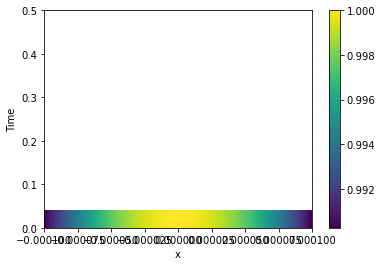

In [65]:
# We can us the py-pde library to solve the differential equation 
import pde 

# Define all the constants in the equation 
mu_p = 300e-4 # m^2 V^-1 s^-1 
T = 10 # K
E_0 = 10 # J
tau_p = 1e-6 # s
e = 1.6e-19 # C
D_p = (mu_p * k_B * T) / e # I think units are Q m^2 s-1 though this doesn't make sense if J is current density.

# Set up a grid of cartesian coordinates for the equation to solve
grid = pde.CartesianGrid([[-1e-4, 1e-4]], [101])

data = np.zeros(101)
data[len(data)//2] = 20

sigma = 1e-6

# Set up a Scalar Field which will correspond to the excess carriers 
#delta_p = pde.ScalarField(grid, data=data)
delta_p = pde.ScalarField.from_expression(grid, f"exp(-x**2/{sigma})")
# Now we can encode the partial differential equation (notes below on the formatting)
# eq = pde.PDE({"p": "D_p * d2_dx2(p) - mu_p * E_0 * d_dx(p) - p / tau_p"}, consts=constants)
eq = pde.PDE({"p": f"(d2_dx2(p)) - {E_0}*(d_dx(p)) - (p)"})
# And solve 
storage = pde.MemoryStorage()
result = eq.solve(delta_p, t_range=0.5, dt = 1e-7, tracker=storage.tracker(0.1))

pde.plot_kymograph(storage)

Plot the analytic result to see what happens 

In [74]:
mu_p = 300e-4 # m^2 V^-1 s^-1 
T = 10 # K
E_0 = 100 # J
tau_p = 1e-6 # s
e = 1.6e-19 # C
D_p = (mu_p * k_B * T) / e # I think units are Q m^2 s-1 though this doesn't make sense if J is current density.
k_B = 1.381E-23 # J/K

def delta_p_analytic(x, t, mu_p=mu_p, D_p=D_p, E_0=E_0, tau_p=tau_p):
    a = np.exp(-t/tau_p)/(4*np.pi*D_p*t)**2
    b = np.exp(-(x-mu_p*E_0*t)**2 / (4*D_p*t))
    return a*b

In [91]:
mu_p = 300e-4 # m^2 V^-1 s^-1 
T = 10 # K
E_0 = 100 # J
tau_p = 1e-6 # s
e = 1.6e-19 # C
D_p = (mu_p * k_B * T) / e # I think units are Q m^2 s-1 though this doesn't make sense if J is current density.
k_B = 1.381E-23 # J/K

def delta_p_analytic(x, t, mu_p=0.3, E_0=1, tau_p=1e-6, T=230):
    D_p = (mu_p*k_B*T) / e
    a = np.exp(-t/tau_p)/(4*np.pi*D_p*t)**2
    b = np.exp(-(x-mu_p*E_0*t)**2 / (4*D_p*t))
    return a*b

In [94]:
x_bound = 1
y_bound = 1e-5
dt = y_bound*1e-2

x = np.linspace(-x_bound, x_bound, 101)
y = np.arange(0, y_bound, dt)

[X, Y] = np.meshgrid(x, y)

/var/folders/0m/gfqnwnj15yb3_ysgltf_03440000gn/T/ipykernel_1340/3017485412.py:11: RuntimeWarning: divide by zero encountered in true_divide
  a = np.exp(-t/tau_p)/(4*np.pi*D_p*t)**2
/var/folders/0m/gfqnwnj15yb3_ysgltf_03440000gn/T/ipykernel_1340/3017485412.py:12: RuntimeWarning: divide by zero encountered in true_divide
  b = np.exp(-(x-mu_p*E_0*t)**2 / (4*D_p*t))
/var/folders/0m/gfqnwnj15yb3_ysgltf_03440000gn/T/ipykernel_1340/3017485412.py:12: RuntimeWarning: invalid value encountered in true_divide
  b = np.exp(-(x-mu_p*E_0*t)**2 / (4*D_p*t))
/var/folders/0m/gfqnwnj15yb3_ysgltf_03440000gn/T/ipykernel_1340/3017485412.py:13: RuntimeWarning: invalid value encountered in multiply
  return a*b


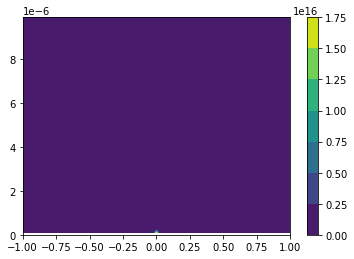

In [95]:
Z = delta_p_analytic(X, Y)

plt.contourf(X, Y, Z)
plt.colorbar()

In [45]:
delta_p_analytic(1e-9, 1e-9)

9.435263246273782e+24